In [1]:
%pip install pandas numpy seaborn tensorflow
%pip install nltk
%pip install lime
%pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt


from lime import lime_text
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer

# Camada de Atenção (Mover para antes da definição do modelo)
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3
        self.W = self.add_weight(name='att_W', shape=(input_shape[-1], 1), initializer='normal', trainable=True)
        self.b = self.add_weight(name='att_b', shape=(input_shape[1], 1), initializer='zeros', trainable=True)
        self.u = self.add_weight(name='att_u', shape=(input_shape[1], 1), initializer='normal', trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        et = K.squeeze(K.tanh(K.dot(x, self.W) + self.b), axis=-1)
        at = K.softmax(et, axis=1)
        at = K.expand_dims(at, axis=-1)
        output = x * at
        output = K.sum(output, axis=1)
        self.attention_weights = at  # Armazenar os pesos para visualização
        return output

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

    def get_config(self):
        config = super().get_config().copy()
        return config

In [4]:
df = pd.read_csv('../Tweets.csv')

In [5]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,3.486,NaN,0.0,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,6.837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0,Bad Flight,7.033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0,Can't Tell,1.0,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [6]:
df.shape

(14640, 15)

<Axes: xlabel='airline_sentiment', ylabel='count'>

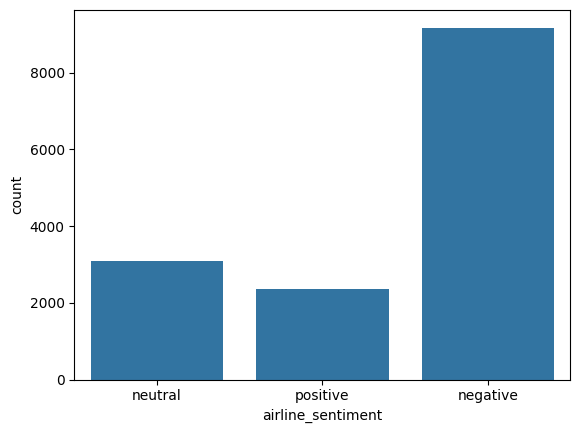

In [8]:
sns.countplot(x='airline_sentiment', data=df)

**Pré-Processamento**

In [9]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re

# Baixar pacotes necessários do NLTK
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")
nltk.download('punkt_tab') # Download the 'punkt_tab' resource

[nltk_data] Downloading package stopwords to C:\Users\LUIRYS
[nltk_data]     SILVA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\LUIRYS
[nltk_data]     SILVA\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\LUIRYS
[nltk_data]     SILVA\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to C:\Users\LUIRYS
[nltk_data]     SILVA\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [10]:
def preprocess_text(text):
    # Converter para minúsculas
    text = text.lower()

    # Remover caracteres especiais e números
    text = re.sub(r"[^a-zA-Z\s]", "", text)

    # Tokenização (dividir em palavras)
    tokens = word_tokenize(text)

    # Remover stopwords
    stop_words = set(stopwords.words("english"))
    tokens = [word for word in tokens if word not in stop_words]

    # Lematização (reduzir palavras à sua forma base)
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Juntar as palavras processadas de volta em uma string
    return " ".join(tokens)

In [11]:
df["clean_text"] = df["text"].apply(preprocess_text)

In [12]:
df.head(5)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,clean_text
0,570306133677760513,neutral,1.0,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada),virginamerica dhepburn said
1,570301130888122368,positive,3.486,NaN,0.0,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),virginamerica plus youve added commercial expe...
2,570301083672813571,neutral,6.837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada),virginamerica didnt today must mean need take ...
3,570301031407624196,negative,1.0,Bad Flight,7.033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),virginamerica really aggressive blast obnoxiou...
4,570300817074462722,negative,1.0,Can't Tell,1.0,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),virginamerica really big bad thing


<Axes: xlabel='airline_sentiment', ylabel='count'>

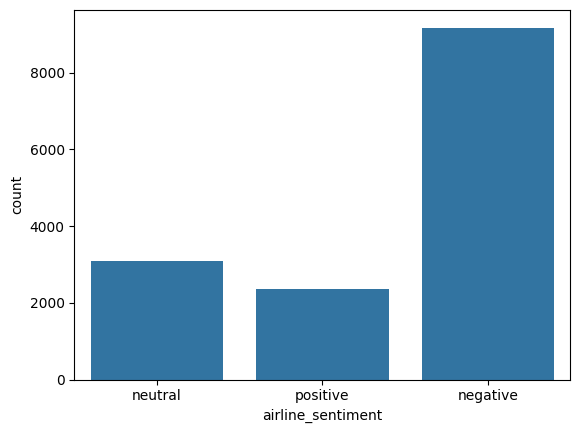

In [13]:
sns.countplot(x="airline_sentiment", data=df) # validando se mudou as classes

In [14]:
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['airline_sentiment'])

In [15]:
X = df['clean_text']
y = df['label_encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#, stratify=y

In [16]:
#tokenização e padding
max_words = 5000
max_len = 100

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

**LSTM**

In [17]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

In [18]:
# Definir o modelo LSTM
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
model.add(LSTM(128, return_sequences=True))  # LSTM com retorno de sequências para atenção
model.add(AttentionLayer())  # Adicionar a camada de atenção
model.add(Dense(3, activation='softmax'))  # 3 saídas para sentimentos (negativo, neutro, positivo)

c:\Users\LUIRYS SILVA\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [19]:
# Compilar o modelo
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Use sparse_categorical_crossentropy se y_train for numérico
              metrics=['accuracy'])

In [20]:
# Treinar o modelo
history = model.fit(X_train_pad, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.1)  # Validação durante o treinamento

Epoch 1/10


c:\Users\LUIRYS SILVA\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\optimizers\base_optimizer.py:870: UserWarning: Gradients do not exist for variables ['sequential/attention_layer/att_u'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


330/330 ━━━━━━━━━━━━━━━━━━━━ 69s 193ms/step - accuracy: 0.6287 - loss: 0.8997 - val_accuracy: 0.6715 - val_loss: 0.7795
Epoch 2/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 70s 211ms/step - accuracy: 0.7205 - loss: 0.6868 - val_accuracy: 0.7654 - val_loss: 0.5784
Epoch 3/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 75s 190ms/step - accuracy: 0.8212 - loss: 0.4616 - val_accuracy: 0.7696 - val_loss: 0.5586
Epoch 4/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 100s 304ms/step - accuracy: 0.8644 - loss: 0.3701 - val_accuracy: 0.7850 - val_loss: 0.5578
Epoch 5/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 145s 312ms/step - accuracy: 0.8843 - loss: 0.3109 - val_accuracy: 0.7713 - val_loss: 0.6185
Epoch 6/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 80s 241ms/step - accuracy: 0.9046 - loss: 0.2632 - val_accuracy: 0.7722 - val_loss: 0.6682
Epoch 7/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 93s 282ms/step - accuracy: 0.9169 - loss: 0.2222 - val_accuracy: 0.7619 - val_loss: 0.7586
Epoch 8/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 112s 189ms/step - accuracy: 0.9324 - loss: 0.1898 - 

**UNDERSAMPLING**

In [21]:
from imblearn.under_sampling import RandomUnderSampler

# Inicializar o RandomUnderSampler
rus = RandomUnderSampler(random_state=42) # random_state para reprodutibilidade

# Aplicar o undersampling aos dados de treino
X_train_resampled, y_train_resampled = rus.fit_resample(X_train_pad, y_train)

In [22]:
# Treinar o modelo com os dados balanceados
history = model.fit(X_train_resampled, y_train_resampled,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.1)

Epoch 1/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 36s 221ms/step - accuracy: 0.9302 - loss: 0.2245 - val_accuracy: 0.8601 - val_loss: 0.5194
Epoch 2/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 36s 189ms/step - accuracy: 0.9490 - loss: 0.1603 - val_accuracy: 0.8479 - val_loss: 0.6078
Epoch 3/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 39s 242ms/step - accuracy: 0.9586 - loss: 0.1320 - val_accuracy: 0.7990 - val_loss: 0.6856
Epoch 4/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 56s 332ms/step - accuracy: 0.9660 - loss: 0.1099 - val_accuracy: 0.8479 - val_loss: 0.6181
Epoch 5/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 37s 230ms/step - accuracy: 0.9722 - loss: 0.0924 - val_accuracy: 0.7867 - val_loss: 0.9679
Epoch 6/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 33s 200ms/step - accuracy: 0.9745 - loss: 0.0834 - val_accuracy: 0.8234 - val_loss: 0.8305
Epoch 7/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 50s 253ms/step - accuracy: 0.9770 - loss: 0.0744 - val_accuracy: 0.7483 - val_loss: 1.1412
Epoch 8/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 37s 222ms/step - accuracy: 0.9765 - loss: 0

<Axes: xlabel='label_encoded', ylabel='count'>

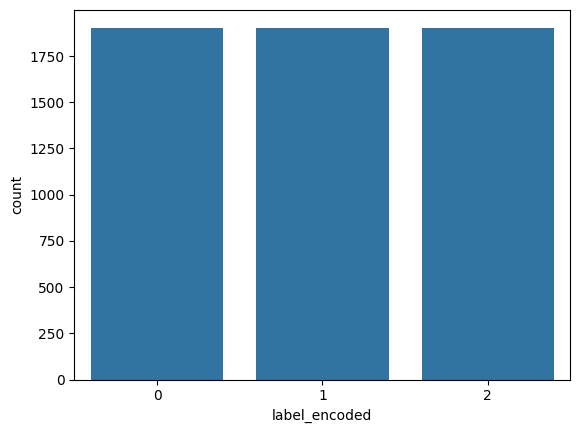

In [23]:
#verificar a nova distribuição de classes
sns.countplot(x=y_train_resampled)

**Métricas**

In [24]:
from sklearn.metrics import classification_report

# Fazer previsões no conjunto de teste
y_pred = model.predict(X_test_pad)
y_pred_classes = np.argmax(y_pred, axis=1)

# Gerar o relatório de classificação
print(classification_report(y_test, y_pred_classes))


92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 76ms/step
              precision    recall  f1-score   support

           0       0.87      0.78      0.82      1889
           1       0.47      0.62      0.53       580
           2       0.64      0.66      0.65       459

    accuracy                           0.73      2928
   macro avg       0.66      0.68      0.67      2928
weighted avg       0.75      0.73      0.74      2928



In [25]:
#acuracia,precisão, recall e f1-score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    return accuracy, precision, recall, f1
# Calcular as métricas
accuracy, precision, recall, f1 = calculate_metrics(y_test, y_pred_classes)
print(f"Acurácia: {accuracy:.4f}")
print(f"Precisão: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Acurácia: 0.7258
Precisão: 0.7517
Recall: 0.7258
F1-Score: 0.7351


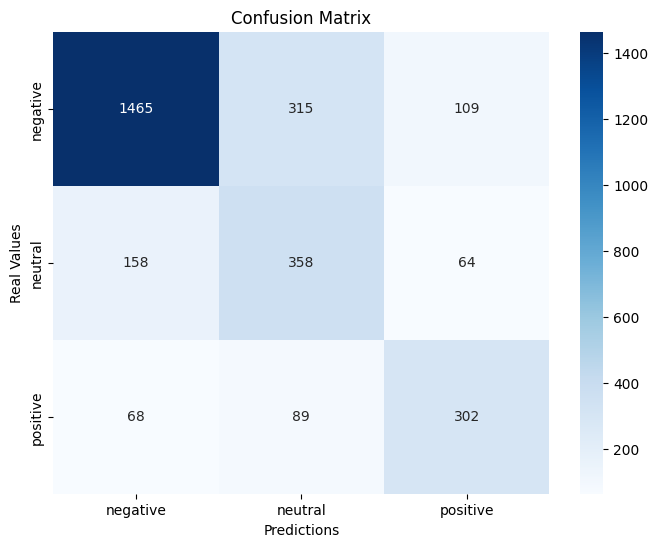

In [26]:
# Calcular a matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Criar o heatmap da matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predictions")
plt.ylabel("Real Values")
plt.title("Confusion Matrix")
plt.show()

**LIME**

In [27]:
from lime.lime_text import LimeTextExplainer

explainer = LimeTextExplainer(class_names=le.classes_)

def predict_proba(texts):
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=max_len)
    predictions = model.predict(padded_sequences)
    return predictions  # Já retorna probabilidades (softmax)

# Solicita ao usuário o número da linha do exemplo
idx = int(input(f"Digite o número da linha (0 a {len(X_test)-1}): "))
sample_text = X_test.iloc[idx]
sample_label = y_test.iloc[idx]

# Predição da classe para o texto selecionado
sample_seq = tokenizer.texts_to_sequences([sample_text])
sample_pad = pad_sequences(sample_seq, maxlen=max_len)
pred_probs = model.predict(sample_pad)
pred_class_idx = pred_probs.argmax(axis=1)[0]
pred_class_name = le.classes_[pred_class_idx]

print(f"Número da linha no X_test: {idx}")
print(f"Original text:\n{sample_text}")
print(f"Classe real: {le.classes_[sample_label]}")
print(f"Classe predita: {pred_class_name}")

explanation = explainer.explain_instance(
    sample_text,
    predict_proba,
    num_features=10
)

print(explanation.as_list())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
Número da linha no X_test: 499
Original text:
americanair narrowly made standbylots snag trip
Classe real: negative
Classe predita: positive
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step
[(np.str_('snag'), -0.37864605101797644), (np.str_('americanair'), -0.2443954000088276), (np.str_('trip'), -0.19615985516226317), (np.str_('made'), -0.19448908743994414), (np.str_('narrowly'), -0.10853464703905484), (np.str_('standbylots'), -0.0038271763237128944)]


In [28]:
# Obtém as palavras mais importantes e seus pesos
lime_features = explanation.as_list()

# Exibe cada palavra com seu impacto na predição
print("Palavras mais importantes e seus pesos:")
for word, weight in lime_features:
    print(f"{word}: {weight:.4f}")

Palavras mais importantes e seus pesos:
snag: -0.3786
americanair: -0.2444
trip: -0.1962
made: -0.1945
narrowly: -0.1085
standbylots: -0.0038


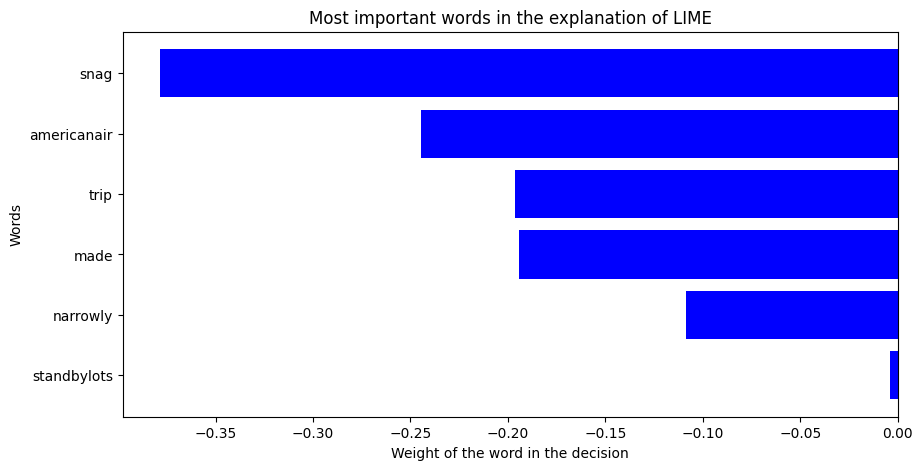

In [29]:
# Separar palavras e pesos
words, weights = zip(*lime_features)

# Criar gráfico de barras
plt.figure(figsize=(10, 5))
plt.barh(words, weights, color="blue")
plt.xlabel("Weight of the word in the decision")
plt.ylabel("Words")
plt.title("Most important words in the explanation of LIME")
plt.gca().invert_yaxis()  # Inverter para mostrar a palavra mais importante no topo
plt.show()

In [30]:
# Obter as palavras mais importantes e seus pesos no geral
words_weights = explanation.as_list()

# Imprimir as palavras e pesos
for word, weight in words_weights:
    print(f"{word}: {weight}")

snag: -0.37864605101797644
americanair: -0.2443954000088276
trip: -0.19615985516226317
made: -0.19448908743994414
narrowly: -0.10853464703905484
standbylots: -0.0038271763237128944


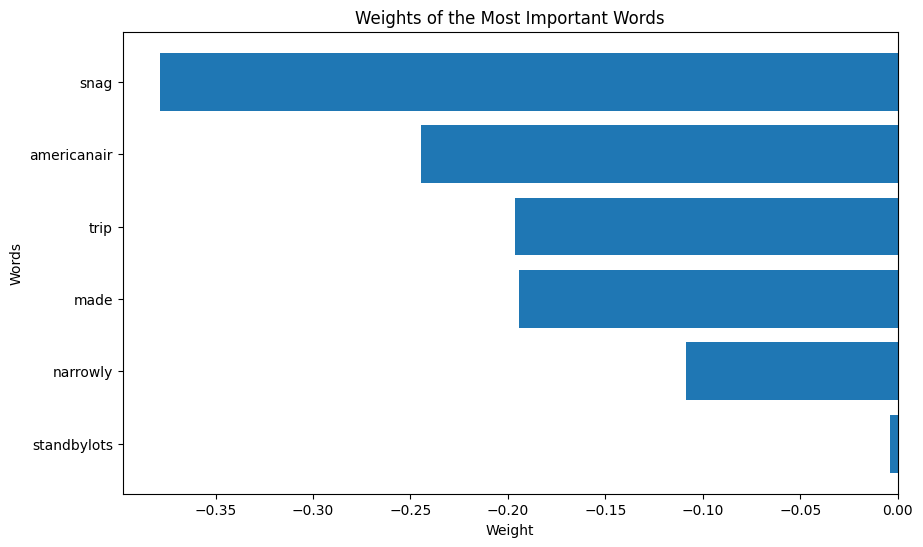

In [31]:
# Obter as palavras mais importantes e seus pesos no geral
words_weights = explanation.as_list()

# Separar palavras e pesos em listas separadas
words = [word for word, weight in words_weights]
weights = [weight for word, weight in words_weights]

# Criar o gráfico de barras horizontais
plt.figure(figsize=(10, 6))  # Ajustar o tamanho da figura, se necessário
plt.barh(words, weights)
plt.xlabel("Weight")
plt.ylabel("Words")
plt.title("Weights of the Most Important Words")
plt.gca().invert_yaxis()  # Inverter o eixo y para que as palavras mais importantes estejam no topo
plt.show()

**Attention Viz**

In [32]:
le.classes_

array(['negative', 'neutral', 'positive'], dtype=object)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step
A classe prevista para o texto é o índice: 1

Palavras do exemplo e seus pesos na decisão da classe prevista (LSTM):
         Feature    Weight
4601     measure  0.289235
2208        park -0.141576
3104  technology -0.409736


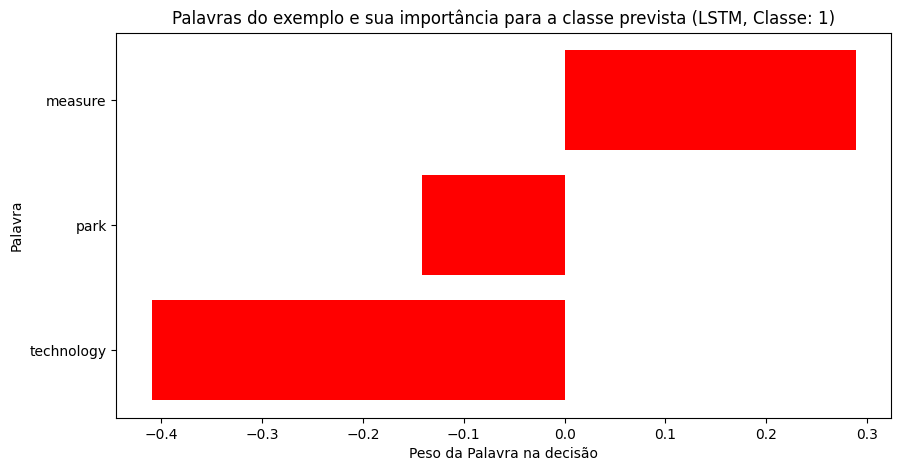

In [33]:
# Definir o texto de exemplo
sample_text = "preliminary estimation technology park measure square meter"

# **Etapa 1: Calcular a importância das palavras para cada classe do modelo LSTM**

# Obter os pesos da camada de Embedding
# Supondo que a camada de embedding é a primeira (índice 0)
embedding_weights = model.layers[0].get_weights()[0]

# Usar tokenizer.index_word para obter as palavras a partir dos índices
nomes_das_features = [tokenizer.index_word.get(i, '<OOV>') for i in range(1, embedding_weights.shape[0] + 1)]

# Obter os pesos da camada Dense (a última camada de saída)
dense_weights = model.layers[-1].get_weights()[0]

# Calcular a importância das palavras para cada classe
num_classes = dense_weights.shape[1]  # Número de classes de saída
importancias_das_features = []
for class_index in range(num_classes):
    # Obter os pesos da camada Dense para a classe atual
    class_weights = dense_weights[:, class_index]

    # Calcular a importância das palavras multiplicando os pesos da camada Dense pelos pesos da camada de Embedding
    word_importances = np.dot(embedding_weights, class_weights)

    importancias_da_classe = pd.DataFrame({'Feature': nomes_das_features, 'Weight': word_importances})
    importancias_da_classe = importancias_da_classe.sort_values(by='Weight', ascending=False)
    importancias_das_features.append(importancias_da_classe)

# **Etapa 2: Prever a classe do sample_text usando o modelo LSTM**

MAX_SEQUENCE_LENGTH = 100 # Substitua pelo valor correto do seu modelo

# Pré-processar o texto de exemplo para o modelo LSTM
sequence = tokenizer.texts_to_sequences([sample_text])
padded_sequence = pad_sequences(sequence, maxlen=MAX_SEQUENCE_LENGTH)

# Fazer a previsão
prediction = model.predict(padded_sequence)

# Obter o índice da classe prevista (a com maior probabilidade)
predicted_class_index = np.argmax(prediction[0])

print(f"A classe prevista para o texto é o índice: {predicted_class_index}")

# **Etapa 3: Visualizar a importância das palavras para a classe prevista**

# Selecionar o DataFrame de importâncias da classe prevista
importancias_da_classe_prevista = importancias_das_features[predicted_class_index]

# Criar um conjunto com as palavras do exemplo, para uma busca mais eficiente
# A regex `\b\w+\b` garante que apenas palavras sejam extraídas, ignorando pontuação
palavras_exemplo = set(re.findall(r'\b\w+\b', sample_text.lower()))

# Filtrar o DataFrame para incluir apenas as palavras que estão no texto de exemplo
importancias_exemplo_lstm = importancias_da_classe_prevista[
    importancias_da_classe_prevista['Feature'].apply(lambda x: x in palavras_exemplo)
]
importancias_exemplo_lstm = importancias_exemplo_lstm.sort_values(by='Weight', ascending=False)

# Exibir as importâncias das palavras do exemplo
print("\nPalavras do exemplo e seus pesos na decisão da classe prevista (LSTM):")
print(importancias_exemplo_lstm[['Feature', 'Weight']])

# **Etapa 4: Plotar o gráfico**

plt.figure(figsize=(10, 5))
plt.barh(importancias_exemplo_lstm['Feature'], importancias_exemplo_lstm['Weight'], color="red")
plt.xlabel("Peso da Palavra na decisão")
plt.ylabel("Palavra")
plt.title(f"Palavras do exemplo e sua importância para a classe prevista (LSTM, Classe: {predicted_class_index})")
plt.gca().invert_yaxis()
plt.show()

In [34]:
class_index = 0
class_weights = dense_weights[:, class_index]
word_importances = np.dot(embedding_weights, class_weights)
importancias_negativas = pd.DataFrame({'Feature': nomes_das_features, 'Weight': word_importances})
importancias_negativas = importancias_negativas.sort_values(by='Weight', ascending=False)

print("Most important features for the Negative class:")
print(importancias_negativas.head(20))

Most important features for the Negative class:
              Feature    Weight
10          cancelled  2.534917
201              nice  1.690772
491              glad  1.685650
1837           locate  1.611401
251            almost  1.566030
1319           become  1.544560
23               cant  1.542454
2453              stt  1.524328
1574         announce  1.481667
4093        therefore  1.459917
4962  upwherewebelong  1.440382
4286     jetblueblues  1.428214
1878          leading  1.385350
843             stuff  1.381343
455              real  1.378176
1134              cry  1.347044
685            switch  1.310465
4024      consistency  1.309902
1633             spot  1.305041
549           atlanta  1.287094


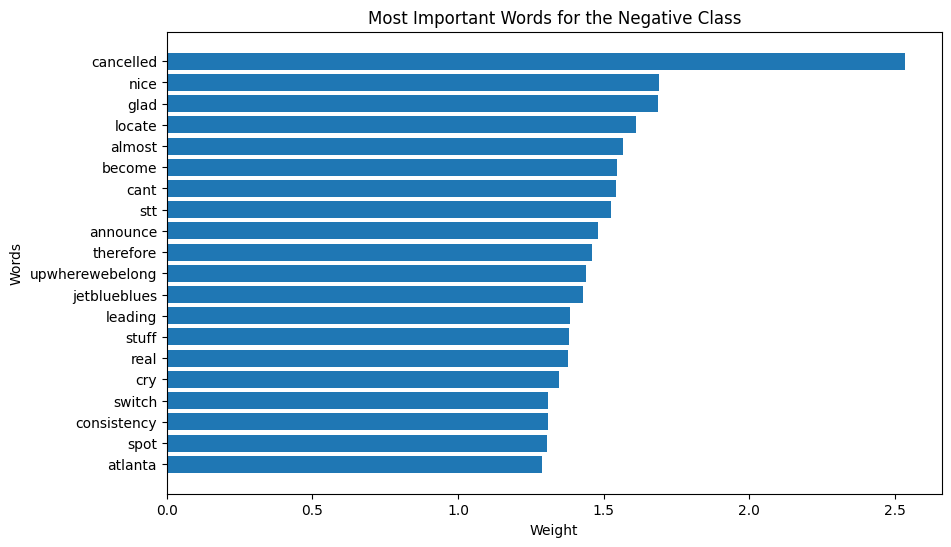

In [35]:
# Criar gráfico de barras para palavras negativas
plt.figure(figsize=(10, 6))
plt.barh(importancias_negativas['Feature'][:20], importancias_negativas['Weight'][:20])
plt.xlabel("Weight")
plt.ylabel("Words")
plt.title("Most Important Words for the Negative Class")
plt.gca().invert_yaxis()  # Inverter o eixo y para melhor visualização
plt.show()

In [36]:
class_index = 1
class_weights = dense_weights[:, class_index]
word_importances = np.dot(embedding_weights, class_weights)
importancias_neutras = pd.DataFrame({'Feature': nomes_das_features, 'Weight': word_importances})
importancias_neutras = importancias_neutras.sort_values(by='Weight', ascending=False)

print("Most important features for the Neutral class:")
print(importancias_neutras.head(20))

Most important features for the Neutral class:
            Feature    Weight
94              let  1.717001
845          street  1.701208
250         amazing  1.671426
34    virginamerica  1.503248
316         twitter  1.487406
967        provided  1.470903
380          return  1.468694
183            also  1.465748
253           speak  1.429342
403            feel  1.366593
378          enough  1.321888
258         helpful  1.290997
103         baggage  1.249937
257            paid  1.234700
374            snow  1.233966
1017       internet  1.198687
452           guess  1.171015
465           award  1.161664
145            keep  1.159437
704        friendly  1.150725


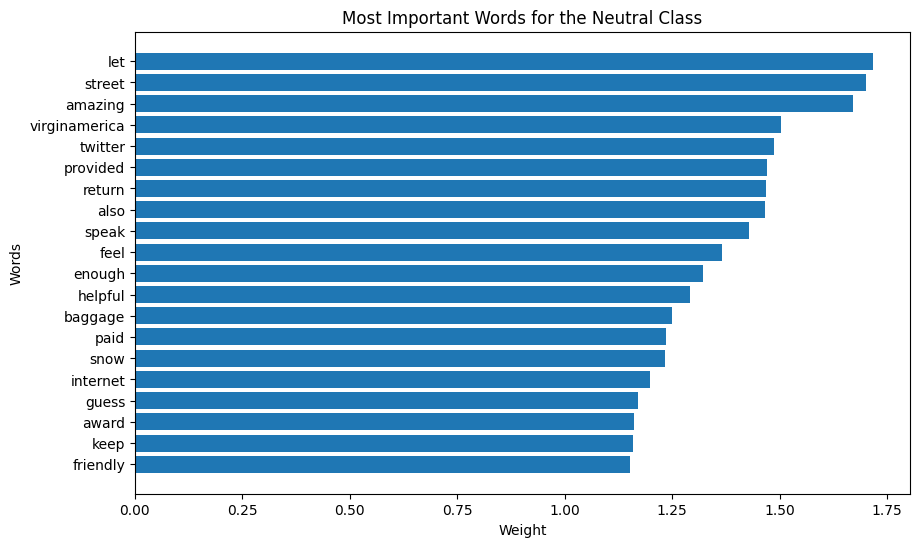

In [37]:
# Criar gráfico de barras para palavras neutras
plt.figure(figsize=(10, 6))
plt.barh(importancias_neutras['Feature'][:20], importancias_neutras['Weight'][:20])
plt.xlabel("Weight")
plt.ylabel("Words")
plt.title("Most Important Words for the Neutral Class")
plt.gca().invert_yaxis()  # Inverter o eixo y para melhor visualização
plt.show()

In [38]:
class_index = 2
class_weights = dense_weights[:, class_index]
word_importances = np.dot(embedding_weights, class_weights)
importancias_positivas = pd.DataFrame({'Feature': nomes_das_features, 'Weight': word_importances})
importancias_positivas = importancias_positivas.sort_values(by='Weight', ascending=False)

print("Most important features for the Positive class:")
print(importancias_positivas.head(20))

Most important features for the Positive class:
                    Feature    Weight
9                    thanks  1.778545
264                   tweet  1.658706
4965  toyingwithouremotions  1.631815
1562                 seeing  1.621121
510                   flyer  1.456670
87                       dm  1.434112
113                   right  1.410287
552                  sunday  1.409744
1919            bostonlogan  1.395885
4949  crazinessintherockies  1.376695
34            virginamerica  1.370498
149                    miss  1.348923
46                     late  1.309254
475                   miami  1.303314
237                  friend  1.298307
711                    list  1.267854
183                    also  1.261914
779                 dealing  1.247413
1981              lufthansa  1.226003
1445                 simply  1.220596


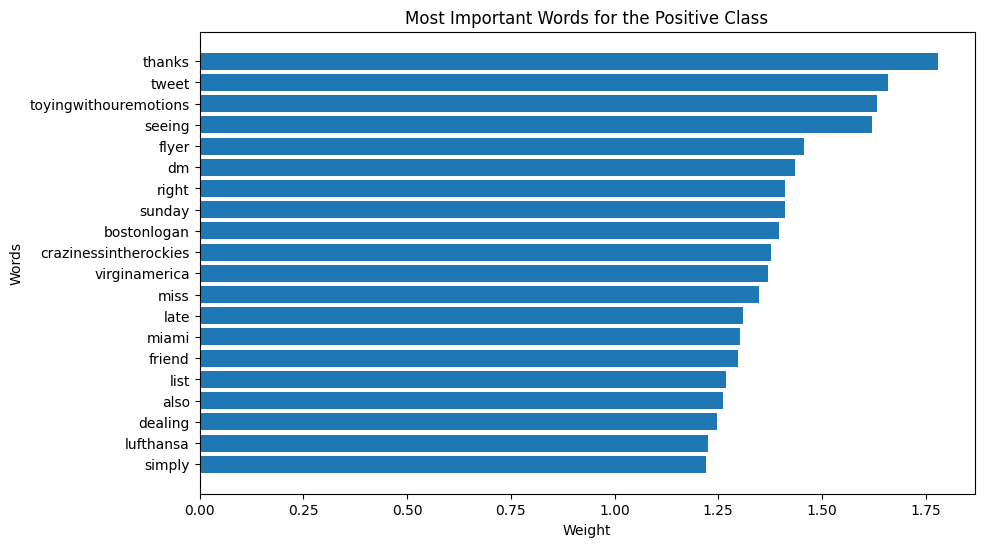

In [39]:
# Criar gráfico de barras para palavras positivas
plt.figure(figsize=(10, 6))
plt.barh(importancias_positivas['Feature'][:20], importancias_positivas['Weight'][:20])
plt.xlabel("Weight")
plt.ylabel("Words")
plt.title("Most Important Words for the Positive Class")
plt.gca().invert_yaxis()  # Inverter o eixo y para melhor visualização
plt.show()